In [ ]:
'''This script is going to create a model to differentiate cases into differnt categories.
Unsupervised learning will be used to create the categories.
The reasoning behind this, is to be able to assign each observation to a category, and then create a custom
regression model for each category to predict the LOS.'''
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
from sklearn.metrics import make_scorer, mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utils import (
    describe_dataframe, df_train_test, graph_results, reg_train_eval
)

In [ ]:
main = pd.read_csv("../data/combo_data.csv")
main

#Identify relevant columns
select_cols = ["LOS" ,
               "YR",  
               "PRNCPAL_DGNS_CD", 
               "CLM_IP_ADMSN_TYPE_CD", 
               "ER_flag", 
               "STATE_CODE", 
               "COUNTY_CD", 
               "BENE_RACE_CD", 
               "ESRD_IND",
               "Age", 
               "TOT_RX_CST_AMT", 
               "NUM_DIAG",
               "SEX_IDENT_CD"]

workingdf_te = main[select_cols].copy()

prncpl_diag_col = pd.DataFrame(data = {"PRNCPL_DGNS_CD": workingdf_te.loc[:,"PRNCPAL_DGNS_CD"]})

print(prncpl_diag_col.shape)

los_col = workingdf_te.loc[:,"LOS"]

print(los_col.shape)

encoder = TargetEncoder(categories='auto', target_type='continuous', smooth='auto', cv=5, random_state=42)

workingdf_te["PRNCPAL_DGNS_CD"] = encoder.fit_transform(prncpl_diag_col, los_col)

workingdf_te = workingdf_te.assign(ESRD_IND = workingdf_te["ESRD_IND"].map({"Y": 1, "0" : 0}))

wdf_rest_te = workingdf_te[workingdf_te["YR"] < 2022]
wdf_2022_te = workingdf_te[workingdf_te["YR"] >= 2022]

ohe = OneHotEncoder(sparse_output=False)

ohe.fit(wdf_rest_te[['CLM_IP_ADMSN_TYPE_CD', 
                  'STATE_CODE', 
                  'BENE_RACE_CD', 
                  "SEX_IDENT_CD"]])

ohe_df_rest_te = pd.DataFrame(data = ohe.transform(wdf_rest_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                          'STATE_CODE', 
                                                          'BENE_RACE_CD',
                                                          "SEX_IDENT_CD"]]), 
             columns=ohe.get_feature_names_out(wdf_rest_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                         'STATE_CODE', 
                                                         'BENE_RACE_CD',
                                                         "SEX_IDENT_CD"]].columns))

ohe.fit(wdf_2022_te[['CLM_IP_ADMSN_TYPE_CD', 
                  'STATE_CODE', 
                  'BENE_RACE_CD', 
                  "SEX_IDENT_CD"]])
ohe_df_2022_te = pd.DataFrame(data = ohe.transform(wdf_2022_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                          'STATE_CODE', 
                                                          'BENE_RACE_CD',
                                                          "SEX_IDENT_CD"]]), 
             columns=ohe.get_feature_names_out(wdf_2022_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                         'STATE_CODE', 
                                                         'BENE_RACE_CD',
                                                         "SEX_IDENT_CD"]].columns))

#drop year, county code, all one hot encoded vars 
wdf_rest_te = wdf_rest_te.drop(columns=["YR", 
                                  "COUNTY_CD", 
                                  'CLM_IP_ADMSN_TYPE_CD', 
                                  'STATE_CODE', 
                                  'BENE_RACE_CD',
                                  "SEX_IDENT_CD"])
wdf_2022_te = wdf_2022_te.drop(columns=["YR", 
                                  "COUNTY_CD", 
                                  'CLM_IP_ADMSN_TYPE_CD', 
                                  'STATE_CODE', 
                                  'BENE_RACE_CD',
                                  "SEX_IDENT_CD"])

wdf_rest_te = pd.concat([wdf_rest_te.reset_index(drop=True), ohe_df_rest_te.reset_index(drop=True)], axis=1)
wdf_2022_te = pd.concat([wdf_2022_te.reset_index(drop=True), ohe_df_2022_te.reset_index(drop=True)], axis=1)

reg_mod_metrics = {"Test":{},
                   "Train":{}}

predictions = {}

X_train_rest_te, X_test_rest_te, y_train_rest_te, y_test_rest_te = df_train_test(wdf_rest_te, "LOS", 0.2)

X_train_2022_te, X_test_2022_te, y_train_2022_te, y_test_2022_te = df_train_test(wdf_2022_te, "LOS", 0.2)

(20867, 1)
(20867,)


In [10]:
#Scaling
scaler = StandardScaler()
X_train_rest_te = scaler.fit_transform(X_train_rest_te)
X_test_rest_te = scaler.transform(X_test_rest_te)
X_train_2022_te = scaler.fit_transform(X_train_2022_te)
X_test_2022_te = scaler.transform(X_test_2022_te)

In [12]:
X_train_2022_te.shape[1]

68

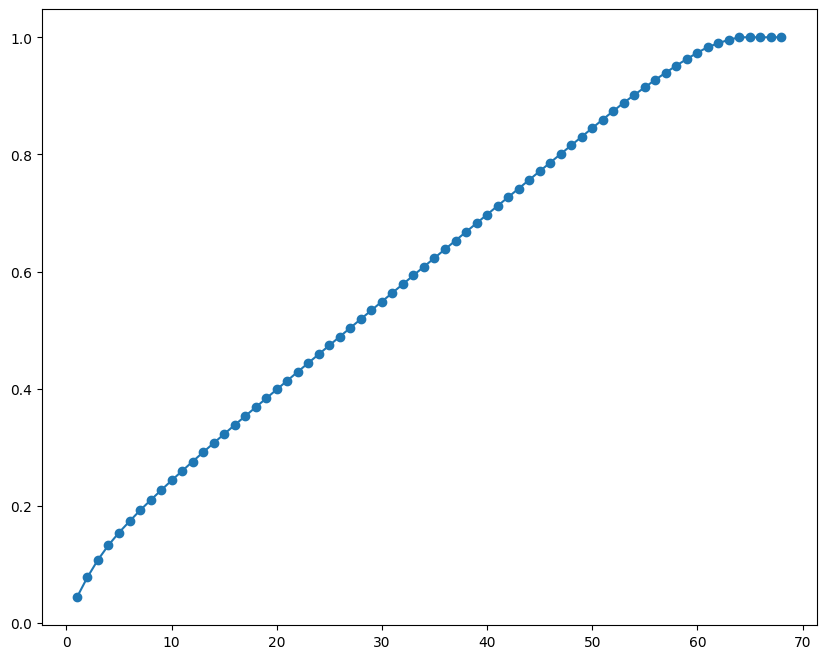

In [15]:
#PCA
pca = PCA()
pca.fit(X_train_rest_te)
pca.explained_variance_ratio_
plt.figure(figsize = (10,8))
plt.plot(range(1,X_train_rest_te.shape[1]+1), pca.explained_variance_ratio_.cumsum(), marker = 'o')

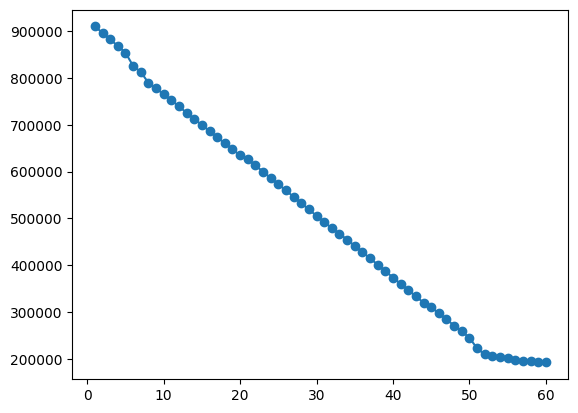

In [ ]:
pca = PCA(n_components=63) #information gain after n_components>63 is negligible
pca.fit(X_train_rest_te)
scores_pca = pca.transform(X_train_rest_te)
wcss = []
for i in range(1,61):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

plt.plot(range(1,61), wcss, marker = 'o')
# Looks like 50 something clusters is the best choice, but that is clinically unreasonable (maybe?)


(20867, 1)
(20867,)


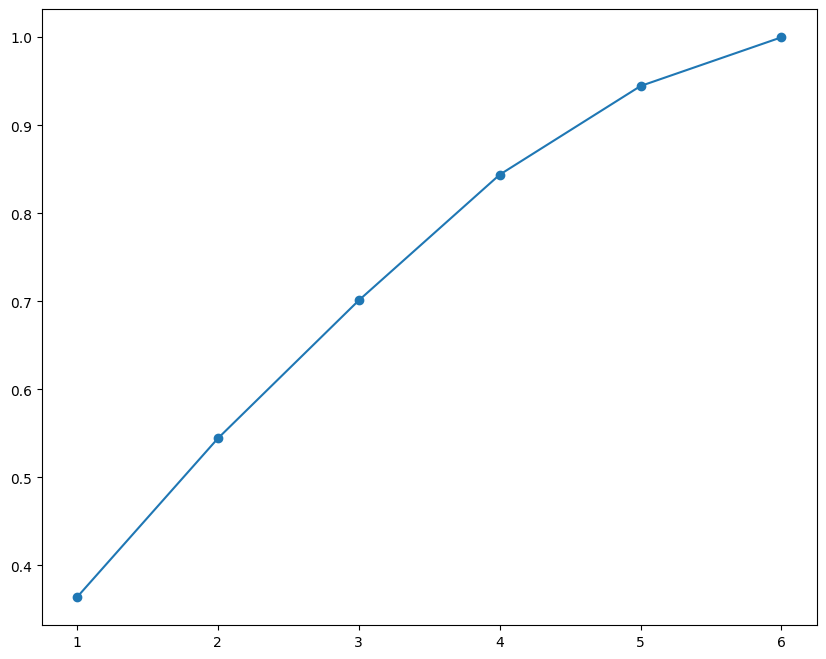

In [22]:
main = pd.read_csv("../data/combo_data.csv")
main

#Identify relevant columns
select_cols = ["LOS" ,
               "YR",  
               "PRNCPAL_DGNS_CD", 
               "CLM_IP_ADMSN_TYPE_CD", 
               "ER_flag", 
               "STATE_CODE", 
               "COUNTY_CD", 
               "BENE_RACE_CD", 
               "ESRD_IND",
               "Age", 
               "TOT_RX_CST_AMT", 
               "NUM_DIAG",
               "SEX_IDENT_CD"]

workingdf_te = main[select_cols].copy()

prncpl_diag_col = pd.DataFrame(data = {"PRNCPL_DGNS_CD": workingdf_te.loc[:,"PRNCPAL_DGNS_CD"]})

print(prncpl_diag_col.shape)

los_col = workingdf_te.loc[:,"LOS"]

print(los_col.shape)

encoder = TargetEncoder(categories='auto', target_type='continuous', smooth='auto', cv=5, random_state=42)

workingdf_te["PRNCPAL_DGNS_CD"] = encoder.fit_transform(prncpl_diag_col, los_col)

workingdf_te = workingdf_te.assign(ESRD_IND = workingdf_te["ESRD_IND"].map({"Y": 1, "0" : 0}))

wdf_rest_te = workingdf_te[workingdf_te["YR"] < 2022]
wdf_2022_te = workingdf_te[workingdf_te["YR"] >= 2022]

ohe = OneHotEncoder(sparse_output=False)

ohe.fit(wdf_rest_te[['CLM_IP_ADMSN_TYPE_CD', 
                  'BENE_RACE_CD', 
                  "SEX_IDENT_CD"]])

ohe_df_rest_te = pd.DataFrame(data = ohe.transform(wdf_rest_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                          'BENE_RACE_CD',
                                                          "SEX_IDENT_CD"]]), 
             columns=ohe.get_feature_names_out(wdf_rest_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                         'BENE_RACE_CD',
                                                         "SEX_IDENT_CD"]].columns))

ohe.fit(wdf_2022_te[['CLM_IP_ADMSN_TYPE_CD', 
                  'BENE_RACE_CD', 
                  "SEX_IDENT_CD"]])
ohe_df_2022_te = pd.DataFrame(data = ohe.transform(wdf_2022_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                          'BENE_RACE_CD',
                                                          "SEX_IDENT_CD"]]), 
             columns=ohe.get_feature_names_out(wdf_2022_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                         'BENE_RACE_CD',
                                                         "SEX_IDENT_CD"]].columns))

#drop year, county code, all one hot encoded vars 
no_state_wdf_rest_te = wdf_rest_te.drop(columns=["YR", 
                                  "COUNTY_CD", 
                                  'CLM_IP_ADMSN_TYPE_CD', 
                                  'STATE_CODE', 
                                  'BENE_RACE_CD',
                                  "SEX_IDENT_CD"])
no_state_wdf_2022_te = wdf_2022_te.drop(columns=["YR", 
                                  "COUNTY_CD", 
                                  'CLM_IP_ADMSN_TYPE_CD', 
                                  'STATE_CODE', 
                                  'BENE_RACE_CD',
                                  "SEX_IDENT_CD"])

X_train_rest_te, X_test_rest_te, y_train_rest_te, y_test_rest_te = df_train_test(no_state_wdf_rest_te, "LOS", 0.2)
X_train_2022_te, X_test_2022_te, y_train_2022_te, y_test_2022_te = df_train_test(no_state_wdf_2022_te, "LOS", 0.2)

scaler = StandardScaler()
X_train_rest_te = scaler.fit_transform(X_train_rest_te)
X_test_rest_te = scaler.transform(X_test_rest_te)
X_train_2022_te = scaler.fit_transform(X_train_2022_te)
X_test_2022_te = scaler.transform(X_test_2022_te)

pca = PCA()
pca.fit(X_train_rest_te)
pca.explained_variance_ratio_
plt.figure(figsize = (10,8))
plt.plot(range(1,X_train_rest_te.shape[1]+1), pca.explained_variance_ratio_.cumsum(), marker = 'o')

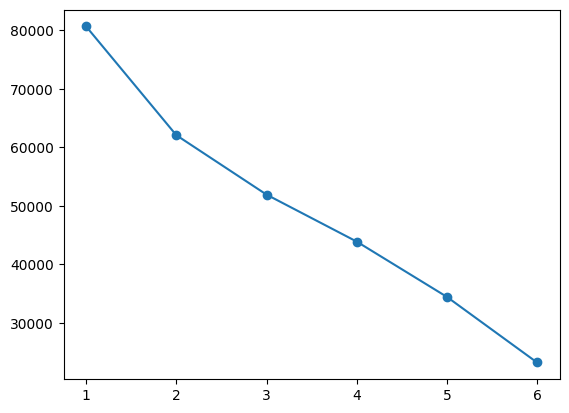

In [25]:
pca = PCA(n_components=6) #information gain after n_components>63 is negligible
pca.fit(X_train_rest_te)
scores_pca = pca.transform(X_train_rest_te)
wcss = []
for i in range(1,7):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

plt.plot(range(1,7), wcss, marker = 'o')
# Looks like 50 something clusters is the best choice, but that is clinically unreasonable (maybe?)